In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds

## The updated model

Separate labor and capital for performance and safety, and have performance level play into safety:

$$p = B(b K_p^\sigma + (1-b) L_p^\sigma)^{\nu / \sigma}$$
$$s = A(a K_s^\rho + (1-a) L_s^\rho)^{\mu / \rho} \cdot p^{-\theta}$$

Payoff is the same as before:
$$\pi_i = \left( \prod_j \frac{s_j}{1+s_j} \right) R_i - \left(1 - \prod_j \frac{s_j}{1+s_j} \right) d_i - r(K_{pi} + K_{si}) - w(L_{pi} + K_{si})$$

In [3]:
class ProdFunc:
    def __init__(
        self,
        A=1.0, a=0.5, rho=1.0, mu=1.0,
        B=1.0, b=0.5, sigma=1.0, nu=1.0,
        theta=1.0
    ):
        self.A = A
        self.a = a
        self.rho = rho
        self.mu = mu
        self.B = B
        self.b = b
        self.sigma = sigma
        self.nu = nu
        self.theta = theta
        self.S = np.vectorize(self.S_)
        self.P = np.vectorize(self.P_)

    def S_(self, K, L, p):
        return self.A * (self.a * K**self.rho + (1-self.a) * L**self.rho)**(self.mu/self.rho) * p**(-self.theta)

    def P_(self, K, L):
        return self.B * (self.b * K**self.sigma + (1-self.b) * L**self.sigma)**(self.nu/self.sigma)

    def plot(self, Kmax=1.0, Lmax=1.0, nticks=100, ncontours=20):
        KK, LL = np.meshgrid(np.linspace(0, Kmax, nticks), np.linspace(0, Lmax,
        nticks))
        PP = self.P(KK, LL)
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
        fig.colorbar(ax0.contour(KK, LL, self.S(KK, LL, PP), ncontours), ax=ax0)
        fig.colorbar(ax1.contour(KK, LL, PP, ncontours), ax=ax1)
        ax0.set_title('S')
        ax1.set_title('P')
        ax0.set_xlabel('K')
        ax1.set_xlabel('K')
        ax0.set_ylabel('L')
        ax1.set_ylabel('L')
        plt.show()

    def get_func(self):
        def func(x):
            # assume x = (Ks, Kp, Ls, Lp)
            p = self.P_(x[1], x[3])
            return np.array([self.S_(x[0], x[2], p), p])
        return func
        
    def get_jac(self):
        def jac(x):
            # assume x = (Ks, Kp, Ls, Lp)
            p = self.P_(x[1], x[3])
            s = self.S_(x[0], x[2], p)
            S_mult = self.A * self.mu * (s / self.A)**((self.mu - self.rho) / self.mu) * p**(-self.theta)
            P_mult = self.B * self.nu * (p / self.B)**((self.nu - self.sigma) / self.nu)
            dPdK = self.b * x[1]**(self.sigma - 1) * P_mult
            dPdL = (1-self.b) * x[3]**(self.sigma - 1) * P_mult
            return np.array(
                [
                    [
                        self.a * x[0]**(self.rho-1) * S_mult,
                        s * (-self.theta) * p**(-self.theta-1) * dPdK,
                        (1-self.a) * x[2]**(self.rho-1) * S_mult,
                        s * (-self.theta) * p**(-self.theta-1) * dPdL
                    ],
                    [
                        0.0,
                        dPdK,
                        0.0,
                        dPdL
                    ]
                ]
            )
        return jac

In [11]:
eps = 1e-10

def default_reward(p):
    return np.sqrt(p+eps)

def default_reward_jac(p):
    return 0.5 * p**(-0.5)

class SingleAgent:
    def __init__(self, d, r, w, R=None, R_jac=None, prodFunc=None):
        self.d = d
        self.r = r
        self.w = w
        self.prodFunc = ProdFunc() if prodFunc is None else prodFunc
        self.R = default_reward if R is None else R
        self.R_jac = default_reward_jac if R_jac is None else R_jac
        self.net_payoff = np.vectorize(self.net_payoff_)

    def net_payoff_(self, Ks, Kp, Ls, Lp):
        p = self.prodFunc.P_(Kp, Lp)
        s = self.prodFunc.S_(Ks, Ls, p)
        proba = s / (1 + s)
        return proba * self.R(p) - (1 - proba) * self.d - self.r * (Ks + Kp) - self.w * (Ls + Lp)

    # def plot(self, Kmax=1.0, Lmax=1.0, nticks=100, ncontours=20, max_=None):
    #     Kspace = np.linspace(0, Kmax, nticks)
    #     Lspace = np.linspace(0, Lmax, nticks)
    #     KKs, KKp, LLs, LLp = np.meshgrid(Kspace, Kspace, Lspace, Lspace)
    #     payoffs = self.net_payoff(KKs, KKp, LLs, LLp)
    #     plt.figure(figsize=(6, 5))
    #     plt.colorbar(plt.contour(KKs, LLs, , ncontours))
    #     if max_ is not None:
    #         plt.scatter(*max_, marker='x')
    #         plt.title('Net payoff as function of K, L; optimum marked with x')
    #     else:
    #         plt.title('Net payoff as function of K, L')
    #     plt.xlabel('K')
    #     plt.ylabel('L')
    #     plt.show()

    def get_func(self):
        return lambda x: -self.net_payoff_(*x)

    def get_jac(self):
        prod_jac = self.prodFunc.get_jac()
        def jac(x):
            p = self.prodFunc.P_(x[1], x[3])
            s = self.prodFunc.S_(x[0], x[2], p)
            proba = s / (1 + s)
            prod_jac_ = prod_jac(x)
            s_ks = prod_jac_[0, 0]
            s_kp = prod_jac_[0, 1]
            s_ls = prod_jac_[0, 2]
            s_lp = prod_jac_[0, 3]
            proba_ks = s_ks / (1 + s)**2
            proba_kp = s_kp / (1 + s)**2
            proba_ls = s_ls / (1 + s)**2
            proba_lp = s_lp / (1 + s)**2
            p_ks = prod_jac_[1, 0]
            p_kp = prod_jac_[1, 1]
            p_ls = prod_jac_[1, 2]
            p_lp = prod_jac_[1, 3]
            R = self.R(p)
            R_jac = self.R_jac(p)
            return -np.array([
                proba_ks * (R + self.d) + proba * R_jac * p_ks - self.r,
                proba_kp * (R + self.d) + proba * R_jac * p_kp - self.r,
                proba_ls * (R + self.d) + proba * R_jac * p_ls - self.w,
                proba_lp * (R + self.d) + proba * R_jac * p_lp - self.w
            ])
        return jac

    def solve(self, x0=(1, 1, 1, 1), verbose=1, plot=False):
        res = minimize(
            self.get_func(), x0, method='trust-constr',
            jac=self.get_jac(),
            bounds=Bounds([0.0, 0.0, 0.0, 0.0], [np.inf, np.inf, np.inf, np.inf]),
            options={
                'xtol': 1e-5,
                # 'maxiter': maxiter,
                'verbose': verbose
            }
        )
        # if plot:
        #     plotsize = int(max(res.x) * 1.5) + 1
        #     self.plot(plotsize, plotsize, max_=res.x)
        return res

In [12]:
prodFunc = ProdFunc(a=0.2, rho=0.5, mu=0.6, b=0.8, sigma=0.5, nu=0.6)
problem = SingleAgent(
    d=0.1, r=0.02, w=0.03,
    prodFunc=prodFunc
)

problem.solve()

`xtol` termination condition is satisfied.
Number of iterations: 189, function evaluations: 192, CG iterations: 196, optimality: 8.04e-03, constraint violation: 0.00e+00, execution time: 0.15 s.


/home/mckay/.local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 196
      cg_stop_cond: 2
            constr: [array([2.77761238, 4.4716723 , 5.41449478, 0.23883675])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.14693617820739746
               fun: -0.4368651664399202
              grad: array([ 0.009084  , -0.00685703, -0.00127378,  0.00094758])
               jac: [<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([ 8.04167285e-03, -6.53043905e-03, -1.23176823e-03,  5.11351968e-05])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 192
              nhev: 0
               nit: 189
             niter: 189
              njev: 192
        optimality: 0.008041672848588963
            status: 

In [19]:
prodFunc = ProdFunc(a=0.2, rho=0.5, mu=0.6, b=0.8, sigma=0.5, nu=0.6)

R = np.linspace(0.01, 0.05, 50)

xs = np.stack([
    SingleAgent(d=0.1, r=r, w=0.03, prodFunc=prodFunc).solve(verbose=0).x
    for r in R
])

/home/mckay/.local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


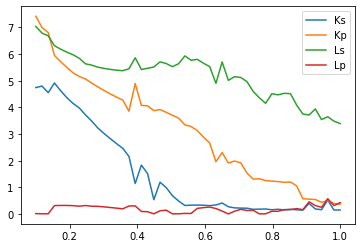

In [20]:
plt.plot(R, xs[:, 0], label='Ks')
plt.plot(R, xs[:, 1], label='Kp')
plt.plot(R, xs[:, 2], label='Ls')
plt.plot(R, xs[:, 3], label='Lp')
plt.legend()
plt.show()

In [21]:
class SingleAgentIntervention(SingleAgent):
    def __init__(self, d, r, w, s, c, R=None, R_jac=None, prodFunc=None):
        super().__init__(d, r, w, R, R_jac, prodFunc)
        self.s = s
        self.c = c

    def net_payoff_(self, Ks, Kp, Ls, Lp):
        p = self.prodFunc.P_(Kp, Lp)
        s = self.prodFunc.S_(Ks, Ls, p) + self.s
        proba = s / (1 + s)
        return proba * self.R(p) - (1 - proba) * self.d - self.r * (Ks + Kp) - self.w * (Ls + Lp) - self.c

    def get_jac(self):
        prod_jac = self.prodFunc.get_jac()
        def jac(x):
            p = self.prodFunc.P_(x[1], x[3])
            s = self.prodFunc.S_(x[0], x[2], p) + self.s
            proba = s / (1 + s)
            prod_jac_ = prod_jac(x)
            s_ks = prod_jac_[0, 0]
            s_kp = prod_jac_[0, 1]
            s_ls = prod_jac_[0, 2]
            s_lp = prod_jac_[0, 3]
            proba_ks = s_ks / (1 + s)**2
            proba_kp = s_kp / (1 + s)**2
            proba_ls = s_ls / (1 + s)**2
            proba_lp = s_lp / (1 + s)**2
            p_ks = prod_jac_[1, 0]
            p_kp = prod_jac_[1, 1]
            p_ls = prod_jac_[1, 2]
            p_lp = prod_jac_[1, 3]
            R = self.R(p)
            R_jac = self.R_jac(p)
            return -np.array([
                proba_ks * (R + self.d) + proba * R_jac * p_ks - self.r,
                proba_kp * (R + self.d) + proba * R_jac * p_kp - self.r,
                proba_ls * (R + self.d) + proba * R_jac * p_ls - self.w,
                proba_lp * (R + self.d) + proba * R_jac * p_lp - self.w
            ])
        return jac

/home/mckay/.local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


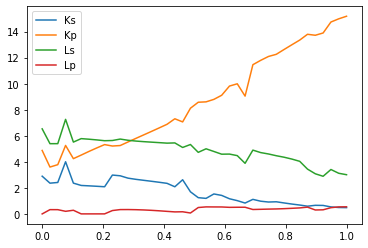

In [36]:
prodFunc = ProdFunc(a=0.2, rho=0.5, mu=0.6, b=0.8, sigma=0.5, nu=0.6)


S = np.linspace(0, 1, 40)
xs = np.stack([
    SingleAgentIntervention(
        d=0.4, r=0.02, w=0.03,
        s=s, c=0.0,
        prodFunc=prodFunc
    ).solve(verbose=0).x
    for s in S
])

plt.plot(S, xs[:, 0], label='Ks')
plt.plot(S, xs[:, 1], label='Kp')
plt.plot(S, xs[:, 2], label='Ls')
plt.plot(S, xs[:, 3], label='Lp')
plt.legend()
plt.show()

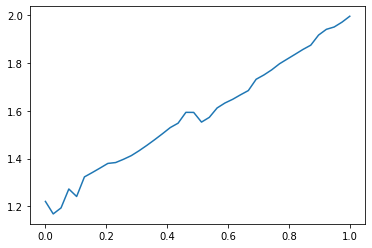

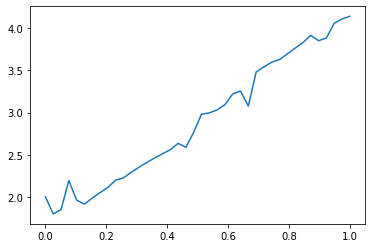

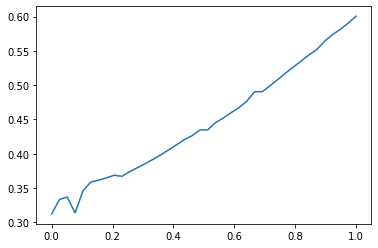

In [42]:
safety = []
performance = []
payoff = []
for x, s in zip(xs, S):
    p = prodFunc.P_(x[1], x[3])
    safety.append(prodFunc.S_(x[0], x[1], p) + s)
    performance.append(p)
    payoff.append(
        SingleAgentIntervention(
            d=0.4, r=0.02, w=0.03,
            s=s, c=0.0,
            prodFunc=prodFunc
        ).net_payoff_(*x)
    )

plt.plot(S, safety)
plt.show()

plt.plot(S, performance)
plt.show()

plt.plot(S, payoff)
plt.show()

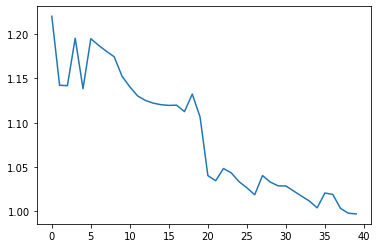

In [40]:
plt.plot(np.array(safety) - S)